# Challenge Product Analyst


## Data Analysis

*The following questions will relate to the dataset "ChallengeData.xls" you will have received along with this challenge that relates to the following hypothetical scenario:*

*You own a company selling bio-products like antibodies online, to scientists. Approximately 4 months ago you ran a test on a page on your site asking users to register and encouraging them to purchase antibodies. There were three variants of the page, A, B & C and based on which page the person saw they were then moved into different cohorts of the same name. The attached data shows what information the user provided while registering and their purchasing behavior in the subsequent months. Assume the cost of antibodies are always the same and all users who saw the page signed up, although not always providing the same level of information. Start by plotting the data in any way you think is useful and use these graphs to justify your answers to the following questions.*

##### Importing the necessary libraries <br />

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import statistics
import statsmodels.api as sm
from statsmodels.formula.api import ols
import collections

##### Loading the data <br />

In [92]:
df1 = pd.read_excel("ChallengeData.xlsx", sheet_name = 'user_data')
df1.head(5)   

,userid,cohort,has_first_name,has_last_name,has_verfied_email,has_phone,number_of_items_watched
0,1101,c,False,True,False,False,0
1,1105,a,True,True,False,True,1
2,1109,c,True,True,True,False,10
3,1118,a,True,False,False,False,0
4,1135,c,True,True,True,False,5


In [93]:
df2 = pd.read_excel("ChallengeData.xlsx", sheet_name = 'week_total_purchases', usecols = 15)
df2.head(5)   

,userid,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
0,1101,0,0,4,1,1,0,0,2,0,0,0,1,0,0,1
1,1105,6,5,3,4,4,2,0,0,1,0,3,3,0,0,1
2,1109,0,0,4,3,4,0,1,1,0,0,1,0,0,0,0
3,1118,0,2,3,5,0,0,0,2,1,0,3,3,0,0,0
4,1135,0,0,4,3,0,3,0,1,0,2,0,1,0,1,2


##### Merging the data <br />

*Q1a: If the goal of the experiment was to sell more antibodies, which variant (A, B or C) will you pick as the winner? Justify your answer. (Please note: To "watch" an item means that the user marks it as relevant on her / his watch list.)*

Since the goal of the experiment is to see which variant sold the most antibodies, let's choose the metric of total number of antobodies sold, which is the sum of all antobidies sold during the course of 15 weeks. Let's create a new dataframe that has the information of which variant of the page the user was introduced to and the total number of antibodies sold
<br />

In [94]:
# Merging the dataframes and including the new metric of total antibodies sold as 'total_antibodies_sold'
dftotal = pd.merge(df1, df2, on=['userid'])
dftotal.drop(['has_first_name', 'has_last_name', 'has_verfied_email', 'has_phone', 'number_of_items_watched'], axis=1, inplace=True)
dftotal['total_antibodies_sold'] = dftotal[['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15']].sum(axis=1)
dftotal.drop(['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'], axis=1, inplace=True)
dftotal['userid'] = pd.Categorical(dftotal.userid)
dftotal.head(5)   

,userid,cohort,total_antibodies_sold
0,1101,c,10
1,1105,a,32
2,1109,c,14
3,1118,a,19
4,1135,c,17


#### Running descriptive statistics <br />

Reshaping the dataframe, plotting boxplots and histograms of each cohorts

DescribeResult(nobs=396, minmax=(3, 48), mean=19.598484848484848, variance=40.600402761795166, skewness=0.34482748036041655, kurtosis=0.7710741204404234)
DescribeResult(nobs=278, minmax=(8, 50), mean=28.636690647482013, variance=62.93251175233098, skewness=0.21845805589425657, kurtosis=-0.13152801010343618)
DescribeResult(nobs=396, minmax=(3, 48), mean=19.598484848484848, variance=40.600402761795166, skewness=0.34482748036041655, kurtosis=0.7710741204404234)


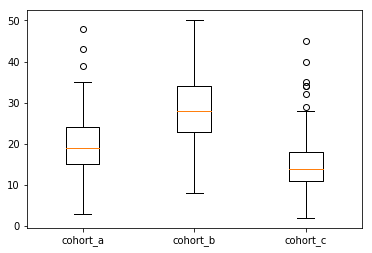

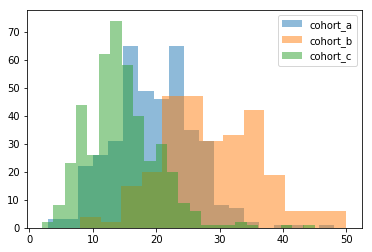

In [95]:
cohort_a = []
cohort_b = []
cohort_c = []

for index, row in dftotal.iterrows():
    if row['cohort'] == "a":
        cohort_a.append(row['total_antibodies_sold'])
    if row['cohort'] == "b":
        cohort_b.append(row['total_antibodies_sold'])
    if row['cohort'] == "c":
        cohort_c.append(row['total_antibodies_sold'])

print(stats.describe(cohort_a))
print(stats.describe(cohort_b))
print(stats.describe(cohort_a))

fig1, ax1 = plt.subplots()
ax1.boxplot([cohort_a, cohort_b, cohort_c], labels = ['cohort_a', 'cohort_b', 'cohort_c',])
plt.show()

plt.hist(cohort_a, bins='auto', alpha=0.5, label='cohort_a')
plt.hist(cohort_b, bins='auto', alpha=0.5, label='cohort_b')
plt.hist(cohort_c, bins='auto', alpha=0.5, label='cohort_c')
plt.legend(loc='upper right')
plt.show()


The null and alternative hypotheses can be stated as below: <br/>

    H0: The cohort means are same 
    HA: The cohort means are different 
    
For the above hypotheses and the data and type of experiment, let's chose a one-way ANOVA test to check for significance between the cohorts.

In order to run the ANOVA test, it is important to check for their assumptions

1) Measures are sampled independantly from each other <br />
2) Residuals follows a normal distribution <br />
3) There is homogenitiy in the measures' variances <br />

It can be assumed that the measures are unique and independant as they are from different users and each user doesn't affect the other

##### Performing one-way ANOVA <br />

In [96]:
model = ols('total_antibodies_sold ~ cohort', data=dftotal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)            
print(anova_table)

                sum_sq      df           F         PR(>F)
cohort    33674.496029     2.0  394.738684  4.413196e-130
Residual  47132.849639  1105.0         NaN            NaN


Setting statistic significance to below 0.05, we see that the value of below this. Hence there exist statistic significance amongst the cohorts 

##### Performing post-hoc pair-wise comparison between cohorts <br />

In [97]:
pair_test = model.t_test_pairwise('cohort')
pair_test.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
b-a,9.038206,0.511023,17.686486,7.858582e-62,8.035520,10.040891,0.0,True
c-a,-5.047794,0.453866,-11.121780,2.601765e-27,-5.938329,-4.157258,0.0,True
c-b,-14.085999,0.501711,-28.075935,2.339451e-131,-15.070413,-13.101586,0.0,True


From the above table, there exists signifcant differences between all the cohorts

#### It can then be concluded that cohort B performed the best

##### Testing for normal distribution of residuals <br />

We run Shapiro-Wilke test to check if they follow a normal distribution

In [98]:
# TODO

If the value of p is non-significant, we can assume they follow a normal distribution. If not, we need to check if the distribution is log-normal or exponential or gamm.

##### Testing for homogenity of variances <br />

In [99]:
# TODO

*Q1b: Can you identify any interesting patterns in the information provided or purchasing behavior of the cohorts? Please describe the hypotheses / research questions you analyze and any theories that could explain the patterns you observe.*
<br />

The first research question would be to analyse the purchase rate of each of the cohorts and see which of them performed better. Also by analysing them against a timeline, we can hypothesize any theories that might explain certain patterns of the purchase rate 

##### Merging the data <br />


In [100]:
dfretention = pd.merge(df1, df2, on=['userid'])
dfretention.drop([ 'has_first_name', 'has_last_name', 'has_verfied_email', 'has_phone', 'number_of_items_watched'], axis=1, inplace=True)
dfretention.head(5)

,userid,cohort,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
0,1101,c,0,0,4,1,1,0,0,2,0,0,0,1,0,0,1
1,1105,a,6,5,3,4,4,2,0,0,1,0,3,3,0,0,1
2,1109,c,0,0,4,3,4,0,1,1,0,0,1,0,0,0,0
3,1118,a,0,2,3,5,0,0,0,2,1,0,3,3,0,0,0
4,1135,c,0,0,4,3,0,3,0,1,0,2,0,1,0,1,2


##### Forming a cohort dataframe <br />
In order to look at purchasing rate between cohorts, let's choose the metric of total weekly purchases made by all users in each cohort


In [101]:
total_weekly_cohort_a = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)
total_weekly_cohort_b = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)
total_weekly_cohort_c = dict.fromkeys(('week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15'), 0)

for index, row in dfretention.iterrows():    
    if row['cohort'] == "a":
        for i in row.index: 
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_a[i] = total_weekly_cohort_a[i] + row[i]
    if row['cohort'] == "b":
        for i in row.index:
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_b[i] = total_weekly_cohort_b[i] + row[i]
    if row['cohort'] == "c":
        for i in row.index: 
            if i in total_weekly_cohort_a.keys():
                total_weekly_cohort_c[i] = total_weekly_cohort_c[i] + row[i]

In [102]:
# Forming a dataframe for a heatmap visualization
dfheat = pd.DataFrame([total_weekly_cohort_a, total_weekly_cohort_b, total_weekly_cohort_c])
dfheat = dfheat[['week 1', 'week 2', 'week 3', 'week 4', 'week 5', 'week 6', 'week 7', 'week 8', 'week 9', 'week 10', 'week 11', 'week 12', 'week 13', 'week 14', 'week 15']]
dfheat.rename(index={0: 'cohort_a', 1: 'cohort_b', 2: 'cohort_c'}, inplace=True)
dfheat.head(5)

,week 1,week 2,week 3,week 4,week 5,week 6,week 7,week 8,week 9,week 10,week 11,week 12,week 13,week 14,week 15
cohort_a,799,666,670,934,521,463,318,629,408,366,323,597,407,359,301
cohort_b,241,288,381,838,427,419,555,964,530,568,489,929,457,390,485
cohort_c,641,600,584,801,517,387,328,472,288,273,233,456,253,267,215


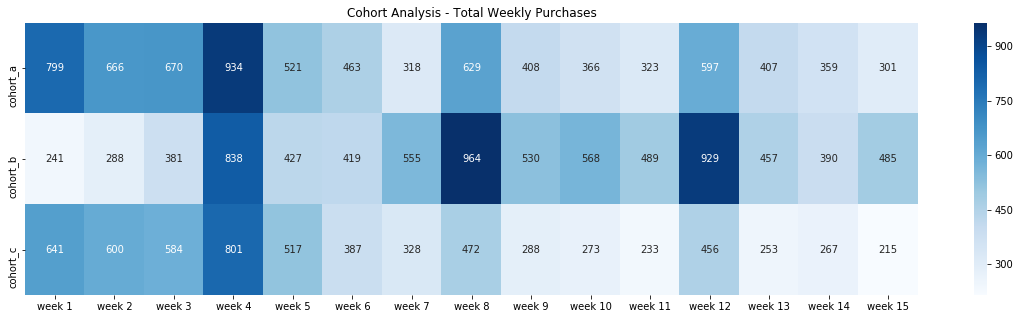

In [108]:
plt.figure(figsize = (20,5))
plt.title('Cohort Analysis - Total Weekly Purchases')
sns.heatmap(data = dfheat, annot = True, fmt='d', cmap = "Blues")
plt.show()

#### From the above visualization, it looks like for cohort A and C, there seems to be a general trend of falling purchases during the course of the 15 weeks. There seems to be some sort of impetus to all cohort at the beginning of week 8 and week 12. It could be that there was a specific marketing campaign or a common events to all cohorts <br />